In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import json
from tqdm import tqdm

import os
import sys
import copy
sys.path.append('..')
from utils import nethook
from utils import model_utils

## Load Model

In [3]:
MODEL_NAME = "gpt2-xl"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=False)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [4]:
model.config.n_embd, model.config.n_layer

(1600, 48)

In [5]:
prompt = [
    "Apple has recently released their iPhone 14 line of",
    "Google has released Pixel 7",
    "I am taking a Machine Learning class",
    "Eiffel Tower is in Paris."
]

# prompt = ["When I try"]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = True,
    max_out_len= 200,
    # debug=True,
    # get_answer_tokens=True,
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

torch.Size([4, 9])
slice(0, 5, None)
Apple has recently released their iPhone 14 line of
Apple has recently released their iPhone 14 line of phones, which includes the iPhone 7 and iPhone 7 Plus. The iPhone 7 and iPhone 7 Plus are the first iPhones to feature a dual-camera system, which is a first for Apple. The dual-camera system is a first for Apple, and it is a first for the iPhone. The dual-camera system is a first for Apple, and it is a first for the iPhone.  The dual-camera system is a first for Apple, and it is a first for the iPhone. The dual-camera system is a first for Apple, and it is a first for the iPhone.  The dual-camera system is a first for Apple, and it is a first for the iPhone. The dual-camera system is a first for Apple, and it is a first for the iPhone.  The dual-camera system is a first for Apple, and it is a first for the iPhone. The dual-camera system is a

Google has released Pixel 7
Google has released Pixel 7 and Pixel 7 Plus, the first Google-made smartphon

In [6]:
len(ret_dict["past_key_values"])

48

In [7]:
ret_dict["past_key_values"][10][0].shape, ret_dict["past_key_values"][10][1].shape

(torch.Size([4, 25, 199, 64]), torch.Size([4, 25, 199, 64]))

## Dataloader (the `4chan` dataset)

In [8]:
import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|/.*/')

def cleanhtml(raw_html):
  raw_html = raw_html.replace("&#039;", "\'")
  cleantext = re.sub(CLEANR, ' ', raw_html)
  split = cleantext.strip().split(" ")
  if(split[0].isnumeric()):
    split = split[1:]
  return " ".join([w for w in split if len(w.strip()) > 0])

cleanhtml("Don&#039;t mess with me")
# cleanhtml('<a href="#p79290593" class="quotelink">&gt;&gt;79290593</a><br><span class="quote">&gt;canada</span><br><br>and you faggots think we&#039;re the worst shit posters')

"Don't mess with me"

In [9]:
def append_eot_token(cleaned_text):
    if(cleaned_text[-1] == '.'):
        return cleaned_text + "<|endoftext|>"
    else:
        split = cleaned_text.split(".")
        ret = ""
        for line in split:
            ret += line + "."
        return ret + "<|endoftext|>"

In [10]:
from torch.utils.data import DataLoader, IterableDataset

class FourChan_Dataset(IterableDataset):
    def __init__(self, file_path, filters = {"min_length": 10}):
        self.file = open(file_path)
        self.filters = filters
    
    def __iter__(self):
        while True:
            content = self.file.readline()
            if(len(content) == 0):
                break
            # print(content, type(content))
            cur_data = json.loads(content)
            for post in cur_data["posts"]:
                if type(post["perspectives"]) is list:
                    continue

                ok = True
                for p in self.filters["perspectives"]:   
                    if(post["perspectives"][p] < self.filters["perspectives"][p]):
                        ok = False
                        break
                if(ok):
                    cleantext = cleanhtml(post["com"])
                    ln = len(cleantext.split(" "))
                    ok = ln > self.filters["min_length"] # and ln < self.filters["max_length"]

                    if(ok):
                        ret = append_eot_token(cleantext)
                        yield (ret, post["perspectives"])
                    else:
                        continue

In [11]:
file_path = "../Data/4chan/pol_062016-112019_labeled.ndjson"
filters = {
    "perspectives": {
        "PROFANITY": 0.8,
        "INSULT": 0.8,
        # "INFLAMMATORY": 0.8,
        # "OBSCENE": 0.8,
        # "TOXICITY": 0.8
        "SEVERE_TOXICITY": 0.8
    },
    "min_length": 50,
    # "max_length": 300,
}


tuning_dataset = FourChan_Dataset(file_path, filters)

In [12]:
limit = 10
for d in tuning_dataset:
    print(d)
    print()
    limit -= 1
    if(limit == 0):
        break

("Just because they do it selfishly doesn't mean it helps americans or you. Fucking christ you ignoramus, they've pissed away america's image in the world, you're one of the most hated nations, they constantly fuck up and lose their shitty power plays overseas, and they want nothing more than to turn you into a slave. They're fucking over the entire country for their selfish pursuits and morons like you are going to have to live with the fallout. Possibly the very literal fallout.<|endoftext|>", {'TOXICITY': 0.9333317, 'SEVERE_TOXICITY': 0.8045205, 'INFLAMMATORY': 0.5840402, 'PROFANITY': 0.9413252, 'INSULT': 0.92957646, 'OBSCENE': 0.98813224, 'SPAM': 0.0023558226})

("merican gubment hates commies, esepcially ones right off our borders who tried to let soviets install a gigantic missile base there. and yeah I agree they shouldn't be trying to blow up it's civilians, CIA FBI everything is out of control, especially the CIA. nobody governs them, they're in control of themself. scary shit

## TUNING

In [13]:
###############################################################################################################
prefix_size = 20
###############################################################################################################
learning_rate = 2e-4
warmup_steps = 200

dataloader_batch_size = 3
optimization_batch_size = 8
max_token_per_comment = 963

save_path = f"../Saved_weights/Prompt-Tuned/{MODEL_NAME}"
###############################################################################################################

In [14]:
embedder = "transformer.wte"
layer_norm_final = "transformer.ln_f"
attention_blocks = [f"transformer.h.{n}" for n in range(model.config.n_layer)]
unembedder = "lm_head"

embedder_module = nethook.get_module(model, embedder)
lm_head = nethook.get_module(model, unembedder)

In [15]:
import random

init_words = ["rude", "mean", "angry"]
def get_initial_prefix(prefix_size = 5):
    words = random.choices(init_words, k=prefix_size)
    sentence = " " + " ".join(words)
    tokenized = tokenizer(sentence, return_tensors = "pt").to(next(model.parameters()).device)
    return embedder_module(tokenized['input_ids'])

get_initial_prefix(7).shape

torch.Size([1, 7, 1600])

In [16]:
soft_embeddings = get_initial_prefix(prefix_size)
init_state = copy.deepcopy(soft_embeddings)
soft_embeddings.requires_grad  = True

print((init_state - soft_embeddings).norm())

# def insert_prompt_embeddings(output, layer, soft_embeddings = soft_embeddings):
#     if(layer != embedder):
#         return output
#     print(output.requires_grad, soft_embeddings.requires_grad)
#     prefix_size = soft_embeddings.shape[1]
#     for batch in output:
#         batch[0:prefix_size] = soft_embeddings
#     return output

def insert_prompt_embeddings_2(output, layer, soft_embeddings = soft_embeddings):
    if(layer != embedder):
        return output
    prefix_size = soft_embeddings.shape[1]
    arr = []
    for batch in output:
        added = torch.cat((soft_embeddings[0], batch[prefix_size:, :]))
        arr.append(added)
    return torch.stack(arr)

inner_rep = torch.randn([2, 17, 1600]).to(next(model.parameters()).device)
prefix_added = insert_prompt_embeddings_2(inner_rep, embedder)

print(inner_rep.shape, prefix_added.shape)
(inner_rep[..., prefix_size:, :] - prefix_added[..., prefix_size:, :]).norm()

tensor(0., device='cuda:0', grad_fn=<CopyBackwards>)
torch.Size([2, 17, 1600]) torch.Size([2, 17, 1600])


tensor(0., device='cuda:0', grad_fn=<CopyBackwards>)

In [17]:
print(soft_embeddings)

tensor([[[-0.0029,  0.0551,  0.0026,  ...,  0.0046, -0.0080, -0.0493],
         [-0.0038,  0.0086, -0.0165,  ..., -0.0019, -0.0222,  0.0099],
         [-0.0029,  0.0551,  0.0026,  ...,  0.0046, -0.0080, -0.0493],
         ...,
         [ 0.0286, -0.0523, -0.0166,  ...,  0.0282, -0.0128, -0.0398],
         [-0.0029,  0.0551,  0.0026,  ...,  0.0046, -0.0080, -0.0493],
         [-0.0029,  0.0551,  0.0026,  ...,  0.0046, -0.0080, -0.0493]]],
       device='cuda:0', requires_grad=True)


In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss

for name, w in model.named_parameters():
    w.requires_grad = False

optimizer = AdamW(
    [soft_embeddings],
    lr = learning_rate,
)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
)

tuning_dataloader = DataLoader(tuning_dataset, batch_size=dataloader_batch_size)


num_prompts_optimized = 0
loss_track = []

for comments, perspectives in tuning_dataloader:
    prompt = list(comments)
    tokenized = tokenizer(
        prompt,
        padding = True,
        return_tensors="pt"
    ).to(next(model.parameters()).device)

    # add soft tokens
    prefix_tokens = torch.ones(len(prompt), prefix_size, dtype = int).to(next(model.parameters()).device) * model.config.bos_token_id
    tokenized["input_ids"] = torch.cat((prefix_tokens, tokenized["input_ids"]), dim = 1)
    prefix_attn = torch.ones(len(prompt), prefix_size, dtype = int).to(next(model.parameters()).device)
    tokenized["attention_mask"] = torch.cat((prefix_attn, tokenized["attention_mask"]), dim = 1)

    # block if number of tokens exceed `max_token_per_comment`
    if(tokenized['input_ids'].shape[1] > max_token_per_comment):
        print(f"BLOCKED ==> {tokenized['input_ids'].shape[1]}")
        continue
    
    # tokenized["input_ids"].require_grad = True
    with nethook.TraceDict(
        model,
        [embedder, layer_norm_final, unembedder],
        edit_output=insert_prompt_embeddings_2
    ) as traces:
        model_output = model(
            **tokenized, 
            labels=tokenized['input_ids']
        )
    
    # remove prefix tokens from loss calculation
    labels = tokenized['input_ids'] # ==> finetuning target
    hidden_states = traces[layer_norm_final].output
    lm_logits = lm_head(hidden_states) # ==> finetuning prediction
    # Shift so that tokens < n predict n
    shift_logits = lm_logits[..., prefix_size:-1, :].contiguous()
    shift_labels = labels[..., prefix_size + 1:].contiguous()

    loss_fct = CrossEntropyLoss()
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

    # print(loss)

    loss.backward()
    # print(soft_embeddings.grad)

    num_prompts_optimized += dataloader_batch_size
    if(True or num_prompts_optimized % optimization_batch_size): # decided to ditch accumulated gradient
        # print("TUNING WEIGHTS")
        loss_track.append(loss.item())

        optimizer.step()
        scheduler.step()
        
        optimizer.zero_grad()
        model.zero_grad()


    if(num_prompts_optimized % 1000 == 0):
        print(f"optimized for {num_prompts_optimized} comments")
        # break
        
    if(num_prompts_optimized % 10000 == 0):
        print("#####################  CHECKPOINT -- saving weights #####################")
        os.makedirs(save_path, exist_ok = True)
        torch.save(soft_embeddings, f"{save_path}/{prefix_size}_prefix_tokens__tuned_with_{num_prompts_optimized}.pth")
        with open(f"{save_path}/loss_track_{num_prompts_optimized}.json", "w") as f:
            json.dump(loss_track, f)
    # break

optimized for 1000 comments


RuntimeError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 47.54 GiB total capacity; 41.72 GiB already allocated; 60.94 MiB free; 44.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [23]:
os.makedirs(save_path, exist_ok = True)
torch.save(soft_embeddings, f"{save_path}/{prefix_size}_prefix_tokens__tuned_with_{num_prompts_optimized}.pth")

In [19]:
print(soft_embeddings)

tensor([[[-0.0107,  0.0553,  0.0037,  ...,  0.0047, -0.0125, -0.0428],
         [ 0.0315, -0.0518, -0.0174,  ...,  0.0333, -0.0146, -0.0296],
         [ 0.0010,  0.0644,  0.0056,  ...,  0.0017, -0.0118, -0.0438],
         ...,
         [-0.0008,  0.0529,  0.0087,  ...,  0.0082, -0.0036, -0.0457],
         [ 0.0324, -0.0508, -0.0146,  ...,  0.0348, -0.0102, -0.0316],
         [ 0.0340, -0.0482, -0.0144,  ...,  0.0348, -0.0077, -0.0320]]],
       device='cuda:0', requires_grad=True)


In [21]:
(soft_embeddings - init_state).norm()

tensor(0.5557, device='cuda:0', grad_fn=<CopyBackwards>)

In [ ]:
class MyClass:
    i = 3

In [56]:
class Check:
    # var = None
    def __init__(self, var):
        Check.var = var

chk = Check(10)
print(chk.var)
# Check.var = 20
print(Check.var)

10
10


In [86]:
prompt = [
    "Apple has recently released their iPhone 14 line of",
    "Google has released Pixel 7",
    "I am taking a Machine Learning class",
    "Eiffel Tower is in Paris.",
    # "The newly elected senator of Arizona"
]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = True,
    max_out_len= 200,
    # debug=True,
    # get_answer_tokens=True,

    prompt_tuning = soft_embeddings
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

10 torch.Size([1, 10, 1600])
torch.Size([5, 19])
slice(0, 15, None)
intervention ==>  transformer.wte output shape ===>  torch.Size([5, 15, 1600])
Apple has recently released their iPhone 14 line of
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Apple has recently released their iPhone 14 line of smartphones, and the iPhone 7 and iPhone 7 Plus are the most popular models. The iPhone 7 and iPhone 7 Plus are the first iPhones to feature a new design, and the iPhone 7 Plus is the first iPhone to feature a dual-camera system. The iPhone 7 Plus is also the first iPhone to feature a new A10 Fusion chip, which is a new processor that is designed to be faster and more efficient than the A9 chip that was used in the iPhone 6s and iPhone 6s Plus.  The iPhone 7 Plus features a 5.5-inch display with a resolution of 1440 x 2560 pixels, which is a higher resolution than the iPhone 6s Plus. The iPhone 7 Plus also featu

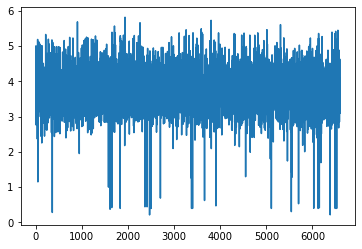

In [82]:
import matplotlib.pyplot as plt

plt.plot(loss_track)